### Libraries and Data

In [27]:
%cd C:\Users\leoma\Desktop\projects\Modelos-de-Pronosticos-Series-Temporales-Python\Prophet+XGBoost

c:\Users\leoma\Desktop\projects\Modelos-de-Pronosticos-Series-Temporales-Python\Prophet+XGBoost


In [28]:
# import libraries
import itertools
from prophet import Prophet
import pandas as pd
import numpy as np

In [29]:
#load the data
data = pd.read_csv('DHS_Daily_Report_2020.csv')
data.head()

,Date,Total Adults in Shelter,Total Children in Shelter,Total Individuals in Shelter,Single Adult Men in Shelter,Single Adult Women in Shelter,Total Single Adults in Shelter,Families with Children in Shelter,Adults in Families with Children in Shelter,Children in Families with Children in Shelter,Total Individuals in Families with Children in Shelter,Adult Families in Shelter,Easter,Thanksgiving,Christmas
0,1/1/2014,28770,21919,50689,7269,2650,9919,10469,14897,21919,1866,3954,0,0,0
1,1/2/2014,28843,21954,50797,7289,2661,9950,10484,14930,21954,1871,3963,0,0,0
2,1/3/2014,28947,22007,50954,7323,2678,10001,10521,14978,22007,1872,3968,0,0,0
3,1/4/2014,28954,22003,50957,7320,2684,10004,10520,14971,22003,1877,3979,0,0,0
4,1/5/2014,28991,21966,50957,7386,2692,10078,10502,14941,21966,1874,3972,0,0,0


* we see first, the date is in the wrong format
* we have a lot of variables here, the one that I´ll use as depende variable will be as "Total I ndiviuals in Shelter" 
* "Easter", "Thanksgiving" and Christmas which I´ll have as regressors

### Data Preparation

In [30]:
# transform the date vatiable
data.Date = pd.to_datetime(data.Date, format = "%m/%d/%Y")
data.Date

0      2014-01-01
1      2014-01-02
2      2014-01-03
3      2014-01-04
4      2014-01-05
          ...    
2552   2020-12-27
2553   2020-12-28
2554   2020-12-29
2555   2020-12-30
2556   2020-12-31
Name: Date, Length: 2557, dtype: datetime64[ns]

In [31]:
df = data.loc[:,
            ["Date", "Total Individuals in Shelter",
            "Easter", "Thanksgiving", "Christmas"]]
df.head()


,Date,Total Individuals in Shelter,Easter,Thanksgiving,Christmas
0,2014-01-01,50689,0,0,0
1,2014-01-02,50797,0,0,0
2,2014-01-03,50954,0,0,0
3,2014-01-04,50957,0,0,0
4,2014-01-05,50957,0,0,0


1. Rename Dependent and time Variable to "y" and "ds"

In [32]:
#RENOMBRAMOS LA VARIABLE QUE QUEREMOS PRONOSTICAR
df = df.rename(columns = {'Total Individuals in Shelter' : 'y', 
                                'Date' : 'ds'})
df.head(1)

,ds,y,Easter,Thanksgiving,Christmas
0,2014-01-01,50689,0,0,0


2. Declare Easter and Thanksgiving as holidays. Combine them. Use pd.concat

In [33]:
#easter
easter_dates = df[df.Easter == 1].ds
easter = pd.DataFrame({'holiday': 'easter',
                               'ds': pd.to_datetime(easter_dates),
                               'lower_windows': -5,
                               'upper_windows': 2})
easter.head(2)

,holiday,ds,lower_windows,upper_windows
109,easter,2014-04-20,-5,2
459,easter,2015-04-05,-5,2


In [35]:
#Thanksgiving
thanksgiving_dates = df[df.Thanksgiving == 1].ds
Thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
                               'ds': pd.to_datetime(thanksgiving_dates),
                               'lower_windows': -5,
                               'upper_windows': 2})
Thanksgiving.head(2)

,holiday,ds,lower_windows,upper_windows
330,thanksgiving,2014-11-27,-5,2
694,thanksgiving,2015-11-26,-5,2


In [36]:
#combine holidays
holidays = pd.concat([easter, Thanksgiving])
holidays

,holiday,ds,lower_windows,upper_windows
109,easter,2014-04-20,-5,2
459,easter,2015-04-05,-5,2
816,easter,2016-03-27,-5,2
1201,easter,2017-04-16,-5,2
1551,easter,2018-04-01,-5,2
1936,easter,2019-04-21,-5,2
2293,easter,2020-04-12,-5,2
330,thanksgiving,2014-11-27,-5,2
694,thanksgiving,2015-11-26,-5,2
1058,thanksgiving,2016-11-24,-5,2


In [60]:
#Create training and test set
test_days = 31
training_set = df.iloc[:-test_days, :]
test_set = df.iloc[-test_days:,:]
training_set.head(1)

,ds,y,Easter,Thanksgiving,Christmas
0,2014-01-01,50689,0,0,0


3. Create Prophet model. Christmas is a regressor

In [63]:
m = Prophet(holidays = holidays,
            seasonality_mode="multiplicative", 
            seasonality_prior_scale=20, 
            holidays_prior_scale=20, 
            changepoint_prior_scale=0.1)
m.add_regressor('Christmas')
m.fit(training_set)

01:04:54 - cmdstanpy - INFO - Chain [1] start processing
01:04:55 - cmdstanpy - INFO - Chain [1] done processing


1. Create future DF with test set length. Add regressor
2. Forecast and create a DF with: trend, weekly, yearly, holidays, multiplicative_terms
3. Concatenate with df. Drop Easter and Thanksgiving
4. Generate Training and Test Set. Isolate X and Y and form XGBoost Matrices
5. Set Parameters and Create XGBoost model
6. Predict. Visualize Test Set and Predictions. Assess model using MAPE

1. Create future DF with test set length. Add regressor

In [65]:
# Create Future Dataframe
future = m.make_future_dataframe(periods= test_days, # serian los dias que voy a necesitar la predicción
                                 freq="D")
future

,ds
0,2014-01-01
1,2014-01-02
2,2014-01-03
3,2014-01-04
4,2014-01-05
...,...
2552,2020-12-27
2553,2020-12-28
2554,2020-12-29
2555,2020-12-30


In [66]:
future = pd.concat([future, df.Christmas], 
                   axis=1)
future.tail()

,ds,Christmas
2552,2020-12-27,0
2553,2020-12-28,0
2554,2020-12-29,0
2555,2020-12-30,0
2556,2020-12-31,0


2. Forecast and create a DF with: trend, weekly, yearly, holidays, multiplicative_terms

In [67]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,easter,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-01-01,50155.051070,50490.567800,51291.069766,50155.051070,50155.051070,0.0,0.0,0.0,0.0,...,0.000667,0.000667,0.000667,0.014378,0.014378,0.014378,0.0,0.0,0.0,50909.637691
1,2014-01-02,50173.682435,50547.159674,51321.146825,50173.682435,50173.682435,0.0,0.0,0.0,0.0,...,0.000605,0.000605,0.000605,0.014568,0.014568,0.014568,0.0,0.0,0.0,50934.985484
2,2014-01-03,50192.313800,50495.226361,51274.772732,50192.313800,50192.313800,0.0,0.0,0.0,0.0,...,-0.000838,-0.000838,-0.000838,0.014820,0.014820,0.014820,0.0,0.0,0.0,50894.137464
3,2014-01-04,50210.945166,50477.897086,51248.060050,50210.945166,50210.945166,0.0,0.0,0.0,0.0,...,-0.001512,-0.001512,-0.001512,0.015133,0.015133,0.015133,0.0,0.0,0.0,50894.874585
4,2014-01-05,50229.576531,50628.562030,51411.395158,50229.576531,50229.576531,0.0,0.0,0.0,0.0,...,0.000175,0.000175,0.000175,0.015505,0.015505,0.015505,0.0,0.0,0.0,51017.171113


3. Concatenate with df. Drop Easter and Thanksgiving

In [68]:
#get some variables 
prophet_variables = forecast.loc[:,["trend","weekly", "yearly", "holidays", "multiplicative_terms"]] # con XGBoost no hay problema con la cantidad de variables a usar
df_xgb = pd.concat([df, prophet_variables], axis=1)
df_xgb.head()

,ds,y,Easter,Thanksgiving,Christmas,trend,weekly,yearly,holidays,multiplicative_terms
0,2014-01-01,50689,0,0,0,50155.051070,0.000667,0.014378,0.0,0.015045
1,2014-01-02,50797,0,0,0,50173.682435,0.000605,0.014568,0.0,0.015173
2,2014-01-03,50954,0,0,0,50192.313800,-0.000838,0.014820,0.0,0.013983
3,2014-01-04,50957,0,0,0,50210.945166,-0.001512,0.015133,0.0,0.013621
4,2014-01-05,50957,0,0,0,50229.576531,0.000175,0.015505,0.0,0.015680


In [71]:
df_xgb = pd.concat([df, prophet_variables], axis=1).drop(columns = ["Easter","Thanksgiving"])
df_xgb.head()

,ds,y,Christmas,trend,weekly,yearly,holidays,multiplicative_terms
0,2014-01-01,50689,0,50155.051070,0.000667,0.014378,0.0,0.015045
1,2014-01-02,50797,0,50173.682435,0.000605,0.014568,0.0,0.015173
2,2014-01-03,50954,0,50192.313800,-0.000838,0.014820,0.0,0.013983
3,2014-01-04,50957,0,50210.945166,-0.001512,0.015133,0.0,0.013621
4,2014-01-05,50957,0,50229.576531,0.000175,0.015505,0.0,0.015680


4. Generate Training and Test Set. Isolate X and Y and form XGBoost Matrices

In [72]:
#Create training and test set
test_days = 31
training_set = df_xgb.iloc[:-test_days, :]
test_set = df_xgb.iloc[-test_days:,:]
training_set.head(1)

,ds,y,Christmas,trend,weekly,yearly,holidays,multiplicative_terms
0,2014-01-01,50689,0,50155.05107,0.000667,0.014378,0.0,0.015045


In [74]:
#isolate X and y
y_train = training_set.y
y_test = test_set.y
X_train = training_set.iloc[:, 2:]  # ds no me importa
X_test = test_set.iloc[:, 2:]  

In [75]:
#Matrices
import xgboost as xgb
Train = xgb.DMatrix(X_train, label = y_train)
Test = xgb.DMatrix(X_test, label = y_test)

5. Set Parameters and Create XGBoost model

In [79]:
#parameters
parameters = {'learning_rate': 0.3, #velocidad en la que queremos que nuestro modelo aprenda / default value
              'max_depth': 6,# tamaño de nuestro arbol / cuantas ramas
              'colsample_bytree': 1, #proporcion de las culumnas / deben incluirse en los modelos--default es 1
              'subsample': 1, # proporcion de observaciones que deben incluirse en cada modelo / default 1 
              'min_child_weight' : 1,
              'gamma': 0,# que tan rapido puede dividirse nuestro arbol 
              'random_state': 1502,
              'eval_metric': 'rmse',
              'objective': 'reg:squarederror'}
              

In [80]:
# XGBoost
model = xgb.train(params=parameters, 
                  dtrain=Train, #conjunto de entrenamiento
                  num_boost_round = 48, #cuantos modelos nos gustraia crear
                  evals = [(Test, 'y')])

[0]	y-rmse:2969.88970
[1]	y-rmse:1800.20806
[2]	y-rmse:1053.47803
[3]	y-rmse:455.61539
[4]	y-rmse:291.41413
[5]	y-rmse:291.58890
[6]	y-rmse:320.24638
[7]	y-rmse:417.91029
[8]	y-rmse:489.20055
[9]	y-rmse:493.99221
[10]	y-rmse:532.78220
[11]	y-rmse:547.90441
[12]	y-rmse:560.76017
[13]	y-rmse:559.54904
[14]	y-rmse:569.75830
[15]	y-rmse:576.95170
[16]	y-rmse:574.37056
[17]	y-rmse:578.26247
[18]	y-rmse:563.42809
[19]	y-rmse:563.11797
[20]	y-rmse:563.41951
[21]	y-rmse:563.44695
[22]	y-rmse:566.43379
[23]	y-rmse:570.16222
[24]	y-rmse:570.58821
[25]	y-rmse:570.51263
[26]	y-rmse:570.63975
[27]	y-rmse:570.59508
[28]	y-rmse:565.86662
[29]	y-rmse:565.09252
[30]	y-rmse:553.64269
[31]	y-rmse:553.21311
[32]	y-rmse:553.01808
[33]	y-rmse:550.99292
[34]	y-rmse:551.03385
[35]	y-rmse:551.08395
[36]	y-rmse:551.19753
[37]	y-rmse:551.13558
[38]	y-rmse:550.80059
[39]	y-rmse:550.73165
[40]	y-rmse:550.69374
[41]	y-rmse:547.52673
[42]	y-rmse:547.42693
[43]	y-rmse:547.51728
[44]	y-rmse:547.80293
[45]	y-rmse:547.8

alrededor de las 20 se estabiliza, podriamos haber usado menos 

6. Predict. Visualize Test Set and Predictions. Assess model using MAPE

In [82]:
#forecasting
predictions = model.predict(Test)
predictions

array([53712.633, 53499.133, 53561.59 , 53548.34 , 53008.766, 52973.84 ,
       53004.04 , 52992.832, 52982.37 , 52982.37 , 53020.406, 53021.062,
       52968.055, 53021.438, 53038.402, 52982.37 , 52977.668, 52972.34 ,
       52971.473, 52973.84 , 52976.613, 52943.6  , 52980.66 , 53011.805,
       52972.273, 53002.363, 52979.1  , 52970.977, 52972.15 , 52903.656,
       52889.484], dtype=float32)

In [87]:
predictions =pd.Series(model.predict(Test), name="XGBoost")
predictions.index = test_set.ds
predictions[:3]

ds
2020-12-01    53712.632812
2020-12-02    53499.132812
2020-12-03    53561.589844
Name: XGBoost, dtype: float32

In [88]:
#Viz
training_set.index = training_set.ds
test_set.index = test_set.ds

<AxesSubplot: xlabel='ds'>

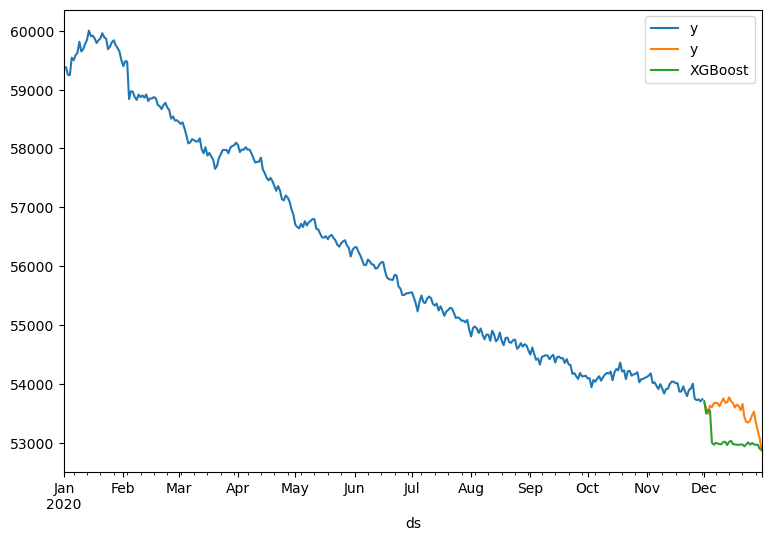

In [93]:
training_set.y['2020-01-01':].plot(figsize=(9,6), legend = True)
test_set.y.plot(legend = True)
predictions.plot(legend=True)

Al menos por ahora nuestro modelos de XGBoost no está haciendo un buen trabajo

In [94]:
# MAPE function
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions)

0.9171208663977298

Entonces tenemos un mapa del 0,91%, que puede parecer bueno, pero en general también se puede decir que es un poco
del tipo de serie temporal bastante predecible...que creo que hay margen de mejora.